# Problema Abordado

# Implementação

## Importações

In [23]:
import torch
from torchvision import transforms, datasets
from torchvision import models
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from datasets import load_dataset
from PIL import Image
import os
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
import time


## Funções Auxiliares

In [24]:

def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()

    for epoch in range(epochs):
        start_time = time.time()

        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        for batch in train_loader:
            images = batch["image_tensor"].to(device)
            captions = batch["tokenized_caption"].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions[:, :-1])  # input tokens
            logits = outputs[:, 1:, :]                 # remove predição do prefixo imagem
            targets = captions[:, 1:]                  # tokens a serem previstos

            # Loss
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Acurácia por token (ignora padding)
            predictions = logits.argmax(dim=-1)        # shape: (B, T)
            mask = targets != 50256                    # 50256 = <eos>, usado como padding
            correct = ((predictions == targets) & mask).sum().item()
            total = mask.sum().item()

            epoch_correct += correct
            epoch_total += total

        # Fim da época
        acc = epoch_correct / epoch_total if epoch_total > 0 else 0.0
        avg_loss = epoch_loss / len(train_loader)
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Acc: {acc:.4f} - Time: {elapsed:.2f}s")


In [5]:
#Função para ajustar dimensões dos tensores do dataset

def collate_fn(batch):
    # Extrai cada campo do batch
    images = [item["image_tensor"] for item in batch]
    captions = [item["caption"] for item in batch]
    input_ids = [item["tokenized_caption"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    images_orig = [item["image_original"] for item in batch]

    # Empilha as imagens (todas já têm o mesmo shape, então stack direto)
    image_tensor = torch.stack(images)

    # Faz padding nas sequências de texto
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=50256)  # eos_token_id para GPT-2
    attention_mask_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        "image_tensor": image_tensor,                    # (B, 3, 224, 224)
        "caption": captions,                             # Lista de strings
        "tokenized_caption": input_ids_padded,           # (B, T)
        "attention_mask": attention_mask_padded,         # (B, T)
        "image_original": images_orig                    # Lista de PIL Images
    }


In [6]:
def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image_tensor"].to(device)
            captions = batch["tokenized_caption"].to(device)

            outputs = model(images, captions[:, :-1])
            loss = criterion(
                outputs.view(-1, outputs.size(-1)),
                captions[:, 1:].reshape(-1)
            )

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")
    return avg_loss

## Dados

### Carregando o dataset


In [7]:


class DeepFashionDataset(Dataset):
    def __init__(self, labelDataset, image_dir, transform=None, tokenizer=None):
        self.df = labelDataset.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

        # Tokenizador padrão: GPT-2
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token  # GPT-2 não tem pad_token original

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        caption = row["caption"]
        img_path = os.path.join(self.image_dir, row["path"].replace("\\", "/"))
        img_path = os.path.normpath(img_path)
        # Imagem original e transformada
        image_pil = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image_pil) if self.transform else image_pil

        # Tokenização (sem truncamento, padding tratado no collate_fn no Dataloader)
        tokens = self.tokenizer(caption, return_tensors="pt")
        input_ids = tokens["input_ids"].squeeze(0)
        attention_mask = tokens["attention_mask"].squeeze(0)

        return {
            "image_tensor": image_tensor,
            "caption": caption,
            "tokenized_caption": input_ids,
            "attention_mask": attention_mask,
            "image_original": image_pil
        }





transform = transforms.Compose([
    transforms.Resize((224,224)), # Padrão dos modelos pretreinados do ImageNet
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],  ## Normalizando dados no padrão do ImageNet
                         std=[0.229, 0.224, 0.225])
])


In [8]:
labels_df = pd.read_csv('/kaggle/input/deep-fashion-datasets/labels_front.csv')
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12278 entries, 0 to 12277
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      12278 non-null  object
 1   caption       12278 non-null  object
 2   path          12278 non-null  object
 3   gender        12278 non-null  object
 4   product_type  12278 non-null  object
 5   product_id    12278 non-null  object
 6   image_type    12278 non-null  object
dtypes: object(7)
memory usage: 671.6+ KB


In [9]:
labels_df['image_id'].head()
labels_df["image_id"] = labels_df["image_id"].str.replace(r"\.jpg$", "", regex=True) + ".jpg"


In [10]:
# Filtrar o DataFrame mantendo apenas image_ids que estão presentes na pasta
images_dir = "/kaggle/input/deep-fashion-datasets/selected_images/selected_images"
available_images = set(os.listdir(images_dir))
labels_df = labels_df[labels_df["image_id"].isin(available_images)].reset_index(drop=True)
labels_df = labels_df.sample(n=2000, random_state=42).reset_index(drop=True)


(8935, 7)

### Data Loader

In [11]:
dataset = DeepFashionDataset(
    labelDataset = labels_df,
    image_dir = "/kaggle/input/deep-fashion-datasets/selected_images/selected_images",
    transform = transform
)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [13]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


batch_size = 16 #Quantos exemplos são processsados juntos durante o treino
#Como não estamos truncando o tamanho dos tokens precisamos garantir que todas as legendas
# tenham o mesmo tamanho de tensor o collate_fn ajustara esse tamanho com

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Rede Implementada

In [14]:
class Encoder(nn.Module):
    def __init__(self, output_dim=256):
        super().__init__()

        # Camadas convolucionais
        self.features = nn.Sequential(
            # Bloco 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Projeção para a dimensão desejada
        self.projection = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.projection(x)
        return x



In [15]:
class Gpt2Decoder(nn.Module):
    def __init__(self, image_dim=256):
        super().__init__()
        self.gpt = GPT2LMHeadModel.from_pretrained("gpt2")


        for param in self.gpt.parameters():
            param.requires_grad = False

        for param in self.gpt.transformer.h[-4:].parameters():
            param.requires_grad = True
        for param in self.gpt.lm_head.parameters():
            param.requires_grad = True

        self.image_proj = nn.Linear(image_dim, self.gpt.config.n_embd)

    def forward(self, textTokens, image_features):
        batch_size = textTokens.size(0)


        img_embed = self.image_proj(image_features).unsqueeze(1)


        text_embeds = self.gpt.transformer.wte(textTokens)

        gpt_input = torch.cat([img_embed, text_embeds], dim=1)

        attention_mask = (textTokens != 50256).float()
        prefix_mask = torch.ones(batch_size, 1, dtype=attention_mask.dtype,
                               device=attention_mask.device)
        full_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

        outputs = self.gpt(inputs_embeds=gpt_input, attention_mask=full_attention_mask)
        return outputs.logits


In [18]:
class ImageCaptionModel(nn.Module):
    def __init__(self, encoder_output_dim=256):
        super().__init__()
        self.encoder = Encoder(output_dim=encoder_output_dim)

        self.decoder = Gpt2Decoder(image_dim=encoder_output_dim)

    def forward(self, images, captions):
        image_features = self.encoder(images)
        logits = self.decoder(captions, image_features)
        return logits

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageCaptionModel().to(device)


criterion = nn.CrossEntropyLoss(ignore_index=50256)  # Ignora padding tokens
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Treinamento da Rede

In [25]:
train_model(model, train_loader, criterion, optimizer, device, epochs= 10)

Epoch 1/10 - Loss: 0.3890 - Acc: 0.8349 - Time: 45.16s
Epoch 2/10 - Loss: 0.3801 - Acc: 0.8373 - Time: 45.74s
Epoch 3/10 - Loss: 0.3768 - Acc: 0.8383 - Time: 46.11s
Epoch 4/10 - Loss: 0.3706 - Acc: 0.8403 - Time: 46.44s
Epoch 5/10 - Loss: 0.3637 - Acc: 0.8429 - Time: 46.19s
Epoch 6/10 - Loss: 0.3592 - Acc: 0.8437 - Time: 46.33s
Epoch 7/10 - Loss: 0.3539 - Acc: 0.8463 - Time: 46.36s
Epoch 8/10 - Loss: 0.3518 - Acc: 0.8468 - Time: 46.67s
Epoch 9/10 - Loss: 0.3446 - Acc: 0.8499 - Time: 45.99s
Epoch 10/10 - Loss: 0.3431 - Acc: 0.8496 - Time: 46.76s


In [26]:
def generate_caption(model, image_tensor, tokenizer, max_length=30, device="cuda"):
    model.eval()

    with torch.no_grad():
        # Extrai vetor da imagem
        image_tensor = image_tensor.unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)
        image_features = model.encoder(image_tensor)         # (1, 256)
        img_embed = model.decoder.image_proj(image_features).unsqueeze(1)  # (1, 1, 768)

        # Começa com token vazio
        input_ids = torch.tensor([[tokenizer.bos_token_id or tokenizer.eos_token_id]], device=device)

        # Lista de embeddings: começa com imagem
        generated = img_embed

        for _ in range(max_length):
            # Embedding do texto gerado até agora
            text_embeds = model.decoder.gpt.transformer.wte(input_ids)
            gpt_input = torch.cat([img_embed, text_embeds], dim=1)

            attention_mask = torch.ones(gpt_input.shape[:2], device=device)

            outputs = model.decoder.gpt(inputs_embeds=gpt_input, attention_mask=attention_mask)
            next_token_logits = outputs.logits[:, -1, :]  # último token
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            if next_token.item() == tokenizer.eos_token_id:
                break

            input_ids = torch.cat([input_ids, next_token], dim=-1)

        caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return caption

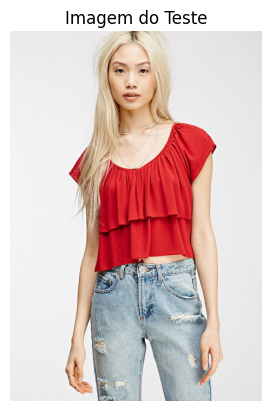

Legenda real:     Her T-shirt has short sleeves, cotton fabric and pure color patterns. It has a crew neckline. There is an accessory in his her neck. The lady wears a ring.
Legenda gerada:   The female is wearing a long-sleeve sweater with graphic patterns. The sweater is with cotton fabric. It has a round neckline. The pants


In [27]:
# Pegando uma amostra do test_loader
batch = next(iter(test_loader))
image_tensor = batch["image_tensor"][0]
caption_real = batch["caption"][0]
image_pil = batch["image_original"][0]

# Tokenizer padrão GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Gerar legenda
caption_pred = generate_caption(model, image_tensor, tokenizer, device=device)

# Mostrar resultado
plt.imshow(image_pil)
plt.axis("off")
plt.title("Imagem do Teste")
plt.show()

print(f"Legenda real:     {caption_real}")
print(f"Legenda gerada:   {caption_pred}")


# Qualidade dos Resultados

# Discussão Geral